# Exploring the Restuarant Scene - Singapore

### Import and install required Libraries

In [1]:
#Install Beautiful Soup
# !conda install -c anaconda beautifulsoup4 -y


In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
#import other libraries needed
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
url = 'https://en.wikipedia.org/wiki/List_of_places_in_Singapore'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

### Data Webscrape Singapore neighborhood data

In [3]:
# The starting point in the page
# Look for the div tags with id = mw-parser-output
sections = soup.find("div", {"class":"mw-parser-output"})


In [4]:
# Look for all the ul tags with no class and append into a list
zones = []

for elem in sections.find_all("ul", {"class":None}, recursive=False):
#     print(f'{elem.text}\n\n')
    zones.append(elem.text)

#Clean up the list to only show the zones and subzones
zones = zones[0:5]
zones

['Bishan[1]\nBishan East\nMarymount\nUpper Thomson\nBukit Merah[2] (Not to be confused with Bukit Merah subzone.)\nAlexandra Hill\nAlexandra North\nBukit Ho Swee\nBukit Merah (Not to be confused with Bukit Merah planning area.)\nCity Terminals (Formerly called "Tanjong Pagar" subzone.)\nDepot Road\nEverton Park\nHenderson Hill\nKampong Tiong Bahru\nMaritime Square (Formerly called "HarbourFront" subzone.)\nRedhill\nSingapore General Hospital\nTelok Blangah Drive\nTelok Blangah Rise\nTelok Blangah Way\nTiong Bahru\nTiong Bahru Station\nBukit Timah[3]\nAnak Bukit\nCoronation Road\nFarrer Court\nHillcrest\nHolland Road\nLeedon Park\nSwiss Club\nUlu Pandan\nDowntown Core[4]\nAnson\nBayfront\nBugis\nCecil\nCentral\nCity Hall\nClifford Pier\nMarina Centre\nMaxwell\nPhillip\nRaffles Place\nTanjong Pagar\nGeylang[5]\nAljunied\nGeylang East\nKallang Way\nMacPherson\nKampong Ubi\nKallang[6]\nBendemeer\nBoon Keng\nCrawford\nGeylang Bahru\nKallang Bahru\nKampong Bugis\nKampong Java\nLavender\nTanj

In [5]:
#Create the dictionary to separate the zones and subzones
sg_zones = {}

#Splitting the zones and subzones
for elem in zones:
    for item in elem.splitlines():
            if '[' in item:
                key = item.split('[', 1)[0] # remove the square brackets
                sg_zones[key] = []
            elif '(' in item:
                item.split('(', 1)[0] # remove the parantheses
            else:
                sg_zones[key].append(item)
                
    for key, value in sg_zones.items(): #add the zone as a subzone to zones with no subzones
         if value == []:
                sg_zones[key].append(key)



### Convert the Zones and Subzones data into a Dataframe

In [6]:
df_sg = pd.DataFrame(sg_zones.items(), columns = ['Zones', 'Neighborhoods']) 
df_sg.head()

,Zones,Neighborhoods
0,Bishan,"[Bishan East, Marymount, Upper Thomson]"
1,Bukit Merah,"[Alexandra Hill, Alexandra North, Bukit Ho Swe..."
2,Bukit Timah,"[Anak Bukit, Coronation Road, Farrer Court, Hi..."
3,Downtown Core,"[Anson, Bayfront, Bugis, Cecil, Central, City ..."
4,Geylang,"[Aljunied, Geylang East, Kallang Way, MacPhers..."


### Split the neighborhoods up into individual rows

In [7]:
for ind in df_sg.index: 
     df_sg['Neighborhoods'][ind] = ",".join(df_sg['Neighborhoods'][ind])
df_sg['Neighborhoods']=df_sg['Neighborhoods'].str.split(",")
df_sg = df_sg.explode("Neighborhoods").reset_index(drop=True)
df_sg.head()

,Zones,Neighborhoods
0,Bishan,Bishan East
1,Bishan,Marymount
2,Bishan,Upper Thomson
3,Bukit Merah,Alexandra Hill
4,Bukit Merah,Alexandra North


### Install geopy for extracting the coordinates 
### Install Folium for map visualization

In [8]:
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


#### Using geopy, I append the list of coordinates of each neighborhood into a list
#### I print out the neighborhoods with no location data, and append it as "NA"

In [9]:
lat = []
lon = []

geolocator = Nominatim(user_agent="foursquare_agent")
# from geopy.extra.rate_limiter import RateLimiter

for hood in df_sg['Neighborhoods']:
    location = geolocator.geocode(hood, country_codes="sg")
    if location is None:
        print (hood)
        lat.append("NA")
        lon.append("NA")
    else:        
        latitude = location.latitude
        longitude = location.longitude 
        
        lat.append(latitude)
        lon.append(longitude)

# df_sg['latitude']=lat
# df_sg['longitude']=lon
#     try:
#         location = geolocator.geocode(hood, country_codes="sg")
#     except AttributeError as error:
#          None

Istana Negara
PLAB
Tanjong Irau
Trafalgar
Serangoon North Industrial Estate
Liu Fang
Peng Siang
Wenya
Gul Basin
Tuas Promenade
Jurong Island and Bukum


In [10]:
#Add latitude and Longitude to df_sg accordingly
df_sg['latitude']=lat
df_sg['longitude']=lon

#Remove hood where location is "NA" from df_sg
df_sg.drop(df_sg.loc[df_sg['latitude'] == "NA"].index, inplace=True)
df_sg.shape

(279, 4)

### Set the coordinates of Singapore and create map visual 

In [11]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [12]:
# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, zone, neighborhood in zip(df_sg['latitude'], df_sg['longitude'], df_sg['Zones'], df_sg['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

### Since the area of Interest is Bedok, I narrowed down the dataframe to the Bedok Zone. 

In [13]:
#Looking to open a restaurant in Bedok
bedok_data = df_sg[df_sg['Zones']=='Bedok'].reset_index(drop=True)
bedok_data.head(10)

,Zones,Neighborhoods,latitude,longitude
0,Bedok,Bayshore,1.31281,103.939
1,Bedok,Bedok North,1.33167,103.918
2,Bedok,Bedok Reservoir,1.34251,103.925
3,Bedok,Bedok South,1.31729,103.95
4,Bedok,Frankel,1.31198,103.92
5,Bedok,Kaki Bukit,1.33603,103.902
6,Bedok,Kembangan,1.32103,103.913
7,Bedok,Siglap,1.317,103.92


#### There are 8 neighborhoods in Bedok, I will create a new map visual showing the area of Bedok

In [14]:
address = 'Bedok, SG'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bedok, Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bedok, Singapore are 1.3239765, 103.930216.


In [15]:
# create map of Bedok using latitude and longitude values
map_bedok = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(bedok_data['latitude'], bedok_data['longitude'], bedok_data['Neighborhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bedok)  
    
map_bedok

### Now that I have the map marked, I will use the Foursquare API to extract additional data of each neighborhood

In [41]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 13FGS0OA0ELDEBO1B15XH0H2C3VWFX1XAI1KX5GSRZ4LX3WL
CLIENT_SECRET:GTCPAXZKHUYWPX1WLPZAPCCUPN13M0ULXLTIODQHP1EOMICN


### Now we can extract the data for each Neighborhood

In [42]:
search_query = 'restaurant'
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
bedok_venues = getNearbyVenues(names=bedok_data['Neighborhoods'], latitudes=bedok_data['latitude'], longitudes=bedok_data['longitude'], radius=1000)
bedok_venues.head()

Bayshore
Bedok North
Bedok Reservoir
Bedok South
Frankel
Kaki Bukit
Kembangan
Siglap


,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bayshore,1.312812,103.939033,Hua Yu Wee Restaurant,1.314572,103.941589,Chinese Restaurant
1,Bayshore,1.312812,103.939033,Han Jia Bak Kut Teh & Pork leg 韩家肉骨茶,1.307112,103.934750,Chinese Restaurant
2,Bayshore,1.312812,103.939033,Song Kee Fried Oyster,1.306877,103.935011,Chinese Restaurant
3,Bayshore,1.312812,103.939033,East Coast Lagoon Food Village,1.306632,103.935207,Food Court
4,Bayshore,1.312812,103.939033,"Chat Masala, Upper East Coast",1.313958,103.931524,Indian Restaurant


In [44]:
bedok_venues_grouped = bedok_venues.groupby('Neighborhoods').count()
bedok_venues_grouped

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Bayshore,44,44,44,44,44,44
Bedok North,65,65,65,65,65,65
Bedok Reservoir,27,27,27,27,27,27
Bedok South,9,9,9,9,9,9
Frankel,63,63,63,63,63,63
Kaki Bukit,13,13,13,13,13,13
Kembangan,44,44,44,44,44,44
Siglap,78,78,78,78,78,78


Text(108.75, 0.5, 'Venue')

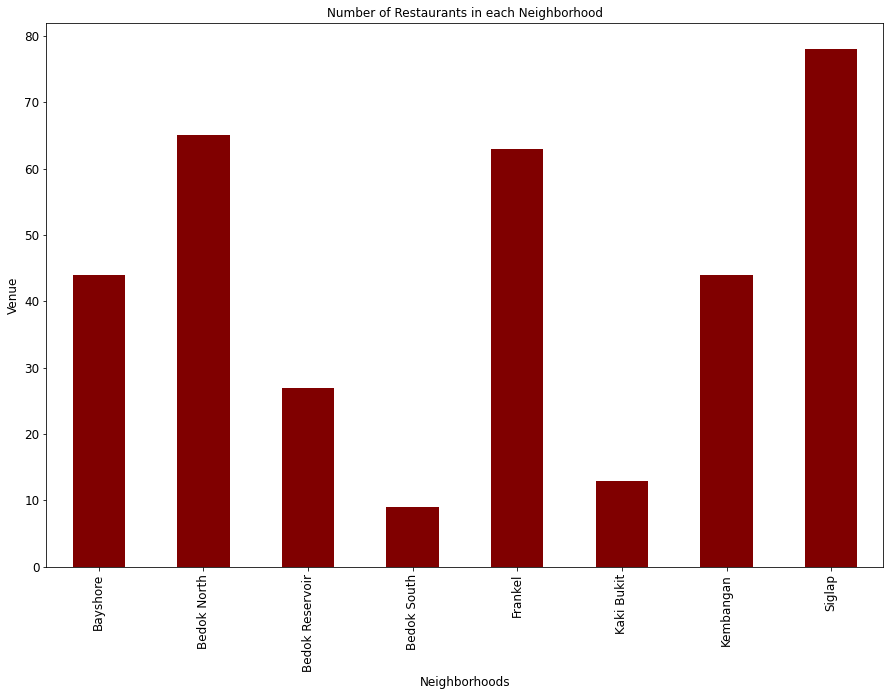

In [60]:
ax = bedok_venues_grouped[['Venue']].plot(kind='bar', title ="Number of Restaurants in each Neighborhood",figsize=(15,10),legend=False, fontsize=12, color = 'Maroon')
plt.savefig("Number of Restaurants.png", dpi=300)
ax.set_xlabel("Neighborhoods",fontsize=12)
ax.set_ylabel("Venue",fontsize=12)

In [46]:
print('There are {} uniques categories.'.format(len(bedok_venues['Venue Category'].unique())))

There are 44 uniques categories.


### Analyze each Neighborhood

In [47]:
# create a dataframe of top 10 categories
bedok_venues_top10 = bedok_venues['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
bedok_venues_top10 = bedok_venues_top10.reset_index()
bedok_venues_top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
bedok_venues_top10

,Venue Category,Frequency
0,Asian Restaurant,47
1,Chinese Restaurant,46
2,Food Court,43
3,Indian Restaurant,29
4,Noodle House,21
5,Café,16
6,Seafood Restaurant,15
7,Bakery,13
8,Pizza Place,9
9,BBQ Joint,9


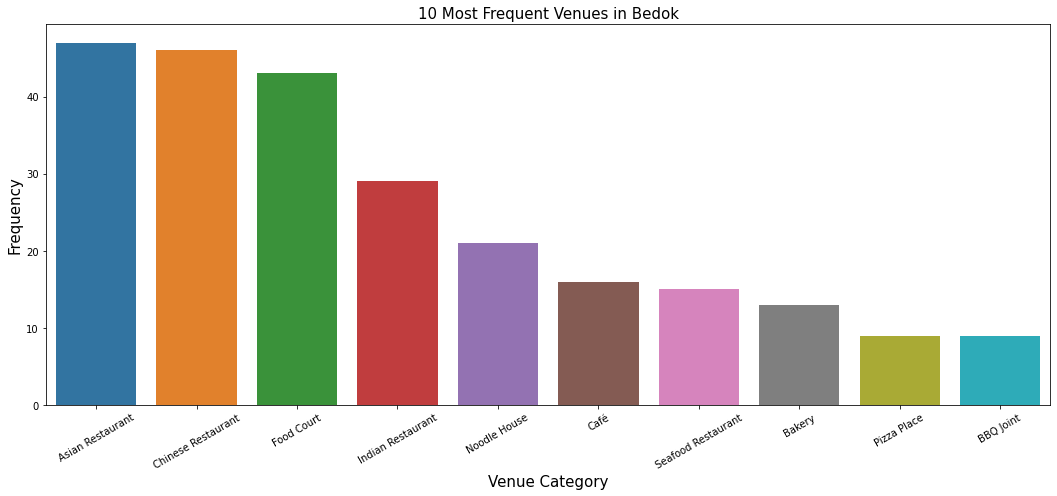

In [61]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=bedok_venues_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequent Venues in Bedok', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [49]:
bedok_onehot = pd.get_dummies(bedok_venues[['Venue Category']], prefix="", prefix_sep="")
bedok_onehot['Neighborhoods'] = bedok_venues['Neighborhoods'] 
fixed_columns = [bedok_onehot.columns[-1]] + list(bedok_onehot.columns[:-1])
bedok_onehot = bedok_onehot[fixed_columns]
bedok_onehot.head()

,Neighborhoods,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Cafeteria,...,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South Indian Restaurant,Spanish Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Bayshore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bayshore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bayshore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bayshore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bayshore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
bedok_grouped = bedok_onehot.groupby('Neighborhoods').mean().reset_index()
bedok_grouped

,Neighborhoods,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Cafeteria,...,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South Indian Restaurant,Spanish Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Bayshore,0.000000,0.204545,0.045455,0.000000,0.045455,0.000000,0.022727,0.000000,0.000000,...,0.022727,0.000000,0.090909,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.045455
1,Bedok North,0.000000,0.107692,0.000000,0.015385,0.061538,0.015385,0.000000,0.000000,0.000000,...,0.000000,0.015385,0.046154,0.000000,0.000000,0.000000,0.030769,0.030769,0.000000,0.000000
2,Bedok Reservoir,0.000000,0.148148,0.074074,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,...,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000
3,Bedok South,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Frankel,0.047619,0.126984,0.031746,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015873,0.031746,0.031746,0.015873,0.015873,0.015873,0.000000,0.015873,0.000000
5,Kaki Bukit,0.000000,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Kembangan,0.000000,0.113636,0.022727,0.000000,0.022727,0.022727,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000
7,Siglap,0.025641,0.115385,0.025641,0.000000,0.038462,0.000000,0.000000,0.012821,0.012821,...,0.012821,0.012821,0.038462,0.025641,0.012821,0.012821,0.000000,0.012821,0.012821,0.000000


In [51]:
num_top_venues = 5

for hood in bedok_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = bedok_grouped[bedok_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bayshore----
                venue  freq
0    Asian Restaurant  0.20
1  Chinese Restaurant  0.16
2  Seafood Restaurant  0.09
3   Indian Restaurant  0.09
4        Noodle House  0.09


----Bedok North----
                  venue  freq
0            Food Court  0.20
1     Indian Restaurant  0.12
2      Asian Restaurant  0.11
3  Fast Food Restaurant  0.08
4    Chinese Restaurant  0.08


----Bedok Reservoir----
                  venue  freq
0      Asian Restaurant  0.15
1            Food Court  0.11
2                  Café  0.11
3             BBQ Joint  0.07
4  Fast Food Restaurant  0.07


----Bedok South----
                        venue  freq
0            Asian Restaurant  0.22
1                  Food Court  0.22
2            Malay Restaurant  0.11
3  Modern European Restaurant  0.11
4          Seafood Restaurant  0.11


----Frankel----
                venue  freq
0  Chinese Restaurant  0.16
1    Asian Restaurant  0.13
2        Noodle House  0.08
3                Café  0.06
4          

### Now we sort out the 10 most common restaurant of each neighborhood

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = bedok_grouped['Neighborhoods']

for ind in np.arange(bedok_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bedok_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bayshore,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Noodle House,Seafood Restaurant,Food Court,BBQ Joint,Bakery,Wings Joint,Salad Place
1,Bedok North,Food Court,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Bakery,Seafood Restaurant,Noodle House,Japanese Restaurant
2,Bedok Reservoir,Asian Restaurant,Food Court,Café,Pizza Place,BBQ Joint,Fast Food Restaurant,Bistro,Food,Chinese Restaurant,Noodle House
3,Bedok South,Asian Restaurant,Food Court,Chinese Restaurant,Noodle House,Seafood Restaurant,Malay Restaurant,Modern European Restaurant,Food Truck,Food,Fast Food Restaurant
4,Frankel,Chinese Restaurant,Asian Restaurant,Noodle House,Café,Food Court,Indian Restaurant,Bakery,American Restaurant,Pizza Place,Seafood Restaurant


## Kmeans Clustering of the neighborhoods
### Import required libraries for Clustering

In [54]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

bedok_grouped_clustering = bedok_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bedok_grouped_clustering)

In [55]:
kmeans.labels_[:] 

array([0, 3, 4, 1, 0, 2, 0, 0], dtype=int32)

In [56]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bedok_merged = bedok_data

# merge bedok_grouped with bedok_data to add latitude/longitude for each neighborhood
bedok_merged = bedok_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')
bedok_merged

,Zones,Neighborhoods,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bedok,Bayshore,1.31281,103.939,0,Asian Restaurant,Chinese Restaurant,Indian Restaurant,Noodle House,Seafood Restaurant,Food Court,BBQ Joint,Bakery,Wings Joint,Salad Place
1,Bedok,Bedok North,1.33167,103.918,3,Food Court,Indian Restaurant,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Bakery,Seafood Restaurant,Noodle House,Japanese Restaurant
2,Bedok,Bedok Reservoir,1.34251,103.925,4,Asian Restaurant,Food Court,Café,Pizza Place,BBQ Joint,Fast Food Restaurant,Bistro,Food,Chinese Restaurant,Noodle House
3,Bedok,Bedok South,1.31729,103.95,1,Asian Restaurant,Food Court,Chinese Restaurant,Noodle House,Seafood Restaurant,Malay Restaurant,Modern European Restaurant,Food Truck,Food,Fast Food Restaurant
4,Bedok,Frankel,1.31198,103.92,0,Chinese Restaurant,Asian Restaurant,Noodle House,Café,Food Court,Indian Restaurant,Bakery,American Restaurant,Pizza Place,Seafood Restaurant
5,Bedok,Kaki Bukit,1.33603,103.902,2,Food Court,Asian Restaurant,Chinese Restaurant,Food,Restaurant,Wings Joint,French Restaurant,Food Truck,Fast Food Restaurant,Diner
6,Bedok,Kembangan,1.32103,103.913,0,Chinese Restaurant,Indian Restaurant,Asian Restaurant,Food Court,Noodle House,Seafood Restaurant,Restaurant,Malay Restaurant,Café,Food Truck
7,Bedok,Siglap,1.317,103.92,0,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Food Court,Gastropub,Noodle House,Pizza Place,Bakery,Café,Seafood Restaurant


In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bedok_merged['latitude'], bedok_merged['longitude'], bedok_merged['Neighborhoods'], bedok_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters